# 导包

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as Data

dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 文本预处理

In [ ]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split() # 转为列表
vocab = list(set(word_sequence)) # 去重
word2idx = {w: i for i, w in enumerate(vocab)} # 添加索引

In [ ]:
# print(word_sequence)
# print(vocab)
# print(word2idx)

# 模型相关参数

In [ ]:
batch_size = 8
embedding_size = 2  # 词向量维度
C = 2 # 窗口大小
voc_size = len(vocab)

# 数据预处理

In [ ]:
# 构建[中心词，上下文]对
skip_grams = []
for idx in range(C, len(word_sequence) - C):
  center = word2idx[word_sequence[idx]] # 中心词索引
  context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1)) # context word idx
  context = [word2idx[word_sequence[i]] for i in context_idx]
  for w in context:
    skip_grams.append([center, w])


In [ ]:
# print(skip_grams)

In [ ]:
# 构建输入输出的one-hot（可以转变为CBOW）
def make_data(skip_grams):
  input_data = []
  output_data = []
  for i in range(len(skip_grams)):
    input_data.append(np.eye(voc_size)[skip_grams[i][0]]) # np.eye()生成对角矩阵
    output_data.append(skip_grams[i][1]) # 输出不用one-hot
  return input_data, output_data

In [ ]:
# 准备批处理
input_data, output_data = make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data, output_data)
loader = Data.DataLoader(dataset, batch_size, True)

In [ ]:
# print(input_data.shape,output_data.shape)

# 构建模型

In [ ]:
class Word2Vec(nn.Module):
  def __init__(self):
    super(Word2Vec, self).__init__()

    # W and V is not Traspose relationship
    self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
    self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))

  def forward(self, X):
    # X : [batch_size, voc_size] one-hot
    # torch.mm only for 2 dim matrix, but torch.matmul can use to any dim
    hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
    output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
    return output_layer

model = Word2Vec().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练

In [ ]:
for epoch in range(2000):
  for i, (batch_x, batch_y) in enumerate(loader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    pred = model(batch_x)
    loss = criterion(pred, batch_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if epoch % 100 == 0:
     print(epoch, loss.item())

0 2.636781692504883
100 2.5256502628326416
200 2.244569778442383
300 2.2515273094177246
400 2.2990562915802
500 1.847149133682251
600 1.6601660251617432
700 2.2679362297058105
800 1.9816515445709229
900 1.8822674751281738
1000 1.9135830402374268
1100 2.3997395038604736
1200 2.052896022796631
1300 1.995782732963562
1400 1.6866400241851807
1500 2.2813127040863037
1600 2.13763689994812
1700 1.6265262365341187
1800 1.8197742700576782
1900 1.9625627994537354


# 可视化

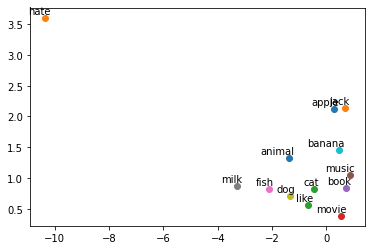

In [ ]:
for i, label in enumerate(vocab):
  W, WT = model.parameters()
  x,y = float(W[i][0]), float(W[i][1])
  plt.scatter(x, y)
  plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()